# How to compare the estimated disk with the simulated disk

In [1]:
## All tests are a combination of a disk, a cube, and a contrast 
from vip_hci.fits import open_fits

disk_id = 2
cube_id = 3
cts_id = 0

sim_id = "X_"+ str(cube_id) + "_" + str(disk_id) + "_" + str(cts_id)

# I recommend (but you can organize yourself keeping track of the ID within the disk estimate 
disk_estimates = open_fits("./"+sim_id)

Fits HDU-0 data successfully loaded. Data shape: (100, 511, 511)


In [8]:
## To compare the test to the ground truth, you need a few things, including:
from vip_hci.fits import open_fits

# Simulated injected (before flux is scaled according to the relative contrast to the star)
ground_truth = open_fits("./disk_sphere/res_disk_" + str(disk_id))
    
# Flux of the star
flux = open_fits("./empty_cubes_sphere/sphere_flux_" + str(cube_id))[0] 

# Aperture where we computed the flux of the disk
app = open_fits("./aperture_disk_sphere/app_disk_" + str(disk_id))  

# Contrast at which the star was injected; the ID corresponds to the index in this list
tested_contrasts = open_fits("./tested_contrasts")
contrast = tested_contrasts[cts_id]

Fits HDU-0 data successfully loaded. Data shape: (1023, 1023)
Fits HDU-0 data successfully loaded. Data shape: (1, 1)
Fits HDU-0 data successfully loaded. Data shape: (511, 511)
Fits HDU-0 data successfully loaded. Data shape: (3,)


In [3]:
## -- Adapt flux (and size, because some images required padding/cropping)
from vip_hci.preproc import frame_pad, frame_crop, cube_crop_frames
import numpy as np 

# This is to fit in shape
size = 162
if disk_id==4 : 
    ground_truth  = frame_pad(ground_truth_flux, size/ground_truth.shape[0])
    app           = frame_crop(app, size)

else :
    ground_truth  = frame_crop(ground_truth, size)
    app           = frame_crop(app, size)

# Crop acordingly the results (can be 1 results or a cube of results)
if len(disk_estimates.shape)==2 : disk_estimates = np.array([disk_estimates])
if len(disk_estimates.shape)>2 and disk_estimates.shape[1]>size: disk_estimates  = cube_crop_frames(disk_estimates, size)
    
# Resclale the ground truth accordlingly to the star flux and choosen contarst
ground_truth_flux = ground_truth*flux*tested_contrasts[cts_id]/np.sum(ground_truth*app)


`Size` is even (while input frame size is odd). Setting `size` to 163 pixels
New shape: (163, 163)
`Size` is even (while input frame size is odd). Setting `size` to 163 pixels
New shape: (163, 163)
`Size` is even (while input frame size is odd). Setting `size` to 163 pixels
New shape: (100, 163, 163)


In [4]:
print(np.sum(ground_truth_flux*app))
print(flux*tested_contrasts[cts_id])

2321.974
[2321.9744]


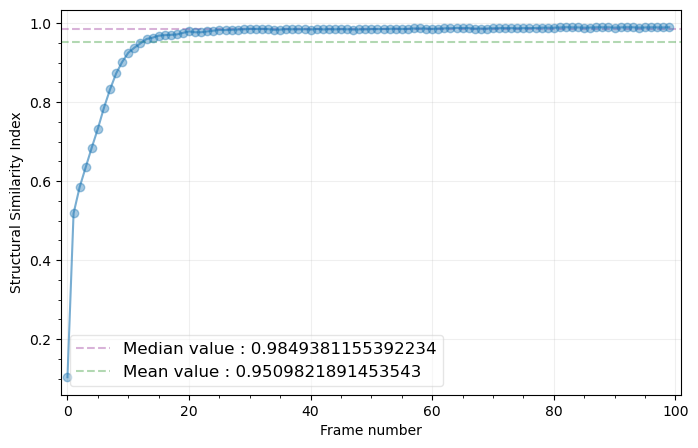

In [5]:
from vip_hci.stats.distances import cube_distance

# disk_estimateS must be a cube.
score  = np.abs(cube_distance(disk_estimates, ground_truth_flux, mode='full', dist="ssim", mask=None, plot=True))

indx = np.unravel_index(np.argmax(score),(disk_estimates.shape[0],))
indx = indx[0] # disk_estimate_flux[indx] is the best disk.

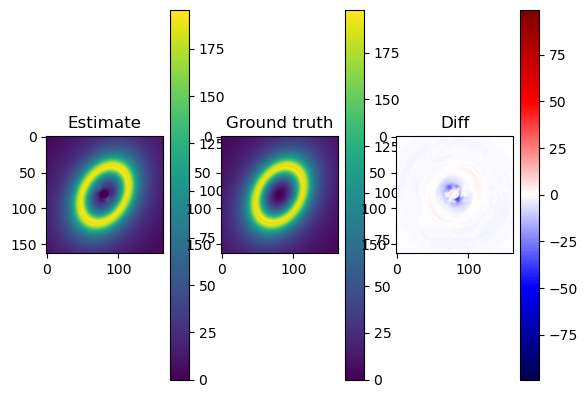

In [6]:
import matplotlib.pyplot as plt

plt.subplot(131)
plt.title("Estimate")
plt.imshow(disk_estimates[indx])
plt.colorbar()
plt.subplot(132)
plt.title("Ground truth")
plt.imshow(ground_truth_flux)
plt.colorbar()
plt.subplot(133)
plt.title("Diff")
diff_scale = 0.5*np.max(ground_truth_flux)
plt.imshow(ground_truth_flux - disk_estimates[indx], cmap="seismic", vmin=-diff_scale, vmax=+diff_scale)
plt.colorbar()


In [7]:
## This little circle function is if you need to create a pup mask.


def circle(shape: tuple, r: float, offset=(0.5, 0.5)):
    """ Create circle of 1 in a 2D matrix of zeros"
       
       Parameters
       ----------

       shape : tuple
           shape x,y of the matrix
       
       r : float
           radius of the circle
       offset : (optional) float
           offset from the center
       
       Returns
       -------
       M : ndarray
           Zeros matrix with a circle filled with ones
       
    """
    assert(len(shape) == 2 or len(shape) == 3)
    if isinstance(offset, (int, float)): offset = (offset, offset)

    nb_f  = shape[0]  if len(shape) == 3 else 0
    shape = shape[1:] if len(shape) == 3 else shape

    M = np.zeros(shape)
    w, l = shape
    for x in range(0, w):
        for y in range(0, l):
            if pow(x - (w // 2) + offset[0], 2) + pow(y - (l // 2) + offset[1], 2) < pow(r, 2):
                M[x, y] = 1

    if nb_f: M = np.tile(M, (nb_f, 1, 1))

    return M

# Exemple usge
edge = disk_estimates.shape[-1]//2
pup = circle(disk_estimates.shape, edge)-circle(disk_estimates.shape, 8)